# Image-Based Lighting
The aim of this project is to explore the concepts of High Dynamic Range (HDR) images and Image-Based Lighting (IBL), which have become increasingly important in the field of computer graphics and digital media. The project will focus on the technical aspects of HDR and IBL, including their creation, manipulation, and application.

---

## 1. Setup env

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os import path
import math

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

import utils
from utils.io import read_image, show_images
from utils.transform import rescale_images_linear, rescale_to_non_zero
from utils.hdr_helpers import gsolve, get_equirectangular_image

## 2. Recovering HDR Radiance Maps 
The first part of this project involves creating a High Dynamic Range (HDR) image from a set of Low Dynamic Range (LDR) images, an operation known as "HDR merging" or "HDR compositing." This complex process blends multiple exposures of the same scene to establish an image with a superior dynamic range compared to any individual images.

#### Reading LDR images

In [3]:
images = ['samples/rec1.jpg', 'samples/rec2.jpg', 'samples/rec3.jpg']
exposures = [1/10.0, 1/40.0, 1/160.0]

ldr_images = np.array([read_image(img) for img in images])
background_image = read_image('samples/raw0.jpg')

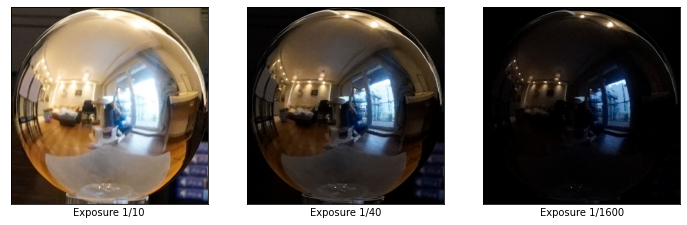

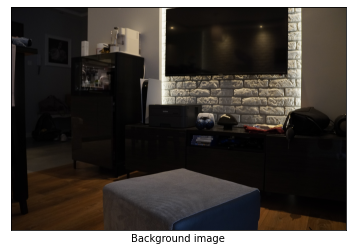

In [4]:
show_images(
    ldr_images, 
    ["Exposure 1/10", "Exposure 1/40", "Exposure 1/1600"],
    figsize=(12, 6)
)
show_images(
    [background_image], 
    ["Background image"],
    figsize=(6, 6)
)

### 2.1. Naive LDR merging 
The first method examined for HDR merging is naive LDR merging. This fundamental technique averages the LDR images at each pixel position. Though a decent starting point for HDR image creation, the method's assumption that pixel values in each image are directly proportional to scene radiance is not always accurate, and therefore, the method might not offer the highest quality HDR image.

In [5]:
def make_hdr_naive(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    """
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    :param ldr_images: N x H x W x 3 shaped numpy array representing N ldr images with width W, height H, and channel size of 3 (RGB)
    :param exposures: list of length N, representing exposures of each images
    :returns: HDR image merged using naive ldr merging implementation and epresending log irradiances for each exposures
    """
    N, H, W, C = ldr_images.shape
    ldr_images_irr = np.array([ldr_image/exposure for ldr_image, exposure in zip(ldr_images, exposures)])
        
    hdr_image= np.zeros((H, W, C))
    for c in range(C):
        hdr_image[:, :, c] = np.mean(ldr_images_irr[:, :, :, c], axis=0)
        
    ldr_images_irr = rescale_to_non_zero(ldr_images_irr)
    log_irradiances = np.log(ldr_images_irr)
    
    return rescale_to_non_zero(hdr_image), log_irradiances

In [6]:
def get_hdr_image(hdr_image: np.array) -> np.array:
    """
    Maps the HDR intensities into a 0 to 1 range. 
    :param hdr_image: HRD image
    :returns: HDR image in format to display
    """
    hdr_image = hdr_image.copy().astype(np.float32)
    hdr_image = hdr_image.copy().astype(np.float32)

    hdr_image[hdr_image != hdr_image] = 0

    if ((hdr_image <= 0).sum() > 0) or ((hdr_image == float('inf')).sum() > 0):
        nearest_nonzero_value = hdr_image[hdr_image > 0].min()
        nearest_non_inf_value = hdr_image[hdr_image != float('inf')].max()
        hdr_image[hdr_image <= 0] = nearest_nonzero_value
        hdr_image[hdr_image == float('inf')] = nearest_non_inf_value
    
    tonemapper = cv2.createTonemapDrago(1.0, 0.7)
    
    return tonemapper.process(hdr_image) 

In [7]:
naive_hdr_image, naive_log_irradiances = make_hdr_naive(ldr_images, exposures)

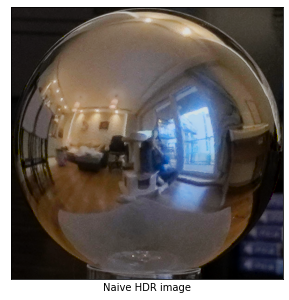

In [8]:
_naive_hdr_image = get_hdr_image(naive_hdr_image)

show_images(
    [_naive_hdr_image], 
    ["Naive HDR image"],
    figsize=(5, 5)
)

### 2.2. Weighted LDR merging 
We then delve into weighted LDR merging, a more sophisticated approach. Instead of just averaging pixel values, it emphasizes pixels containing superior quality information, thereby creating an HDR image that is more detailed and more accurately reflects the original scene's dynamic range.


In [9]:
def make_hdr_weighted(ldr_images: np.ndarray, exposures: list) -> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    :param ldr_images: N ldr images with width W, height H, and channel size of 3 (RGB)
    :param exposure_times: list of length N, representing exposures of each images
    :return: H x W x 3 shaped numpy array representing HDR image merged without under - over exposed regions
    '''
    N, H, W, C = ldr_images.shape

    ldr_images_irr = np.array([ldr_image/exposure for ldr_image, exposure in zip(ldr_images, exposures)])
    
    w = np.vectorize(lambda z: float(129-abs(z-128)))
    weights = np.array([w(ldr_image_irr) for ldr_image_irr in ldr_images_irr])
    
    ldr_images_irr_weighted = ldr_images_irr * weights
    
    hdr_image = np.sum(ldr_images_irr_weighted, axis=0) / np.sum(weights, axis=0)
    
    ldr_images_irr = rescale_to_non_zero(ldr_images_irr)
    log_irradiances = np.log(ldr_images_irr)
    
    return rescale_to_non_zero(hdr_image), log_irradiances

In [10]:
weighted_hdr_image, weighted_log_irradiances = make_hdr_weighted(ldr_images, exposures)

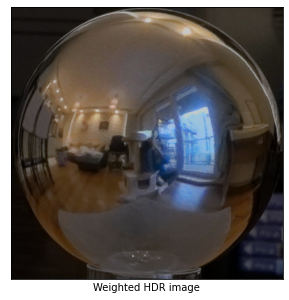

In [11]:
_weighted_hdr_image = get_hdr_image(weighted_hdr_image)

show_images(
    [_weighted_hdr_image], 
    ["Weighted HDR image"],
    figsize=(5, 5)
)

### 2.3. LDR merging with camera response function estimation 
The third method is an even more intricate approach, employing the camera response function (CRF) to create HDR images. By estimating the CRF of the camera used to capture the LDR images, we can enhance the quality of the merged HDR image.

In [12]:
def make_hdr_estimation(ldr_images: np.ndarray, exposures: list, lm)-> (np.ndarray, np.ndarray):
    '''
    Makes HDR image using multiple LDR images, and its corresponding exposure values.
    :param ldr_images: N ldr images with width W, height H, and channel size of 3 (RGB)
    :param exposures: list of length N, representing exposures of each images.
    :param lm: the smoothing parameter
    :return: HDR image merged using gsolve, log irradiances for each exposures, and g values of each pixel intensities at each channels (used for plotting)
    '''
    N, H, W, C = ldr_images.shape
    ldr_images = (ldr_images * 255).astype("uint8")
    
    hdr_image = np.zeros((H, W, C))
    log_irradiances = np.zeros((N, H, W, C))
    g_per_exposures = np.zeros((C, 256))
        
    randsize = 1000
    
    Z = np.zeros((N, randsize))
    B = np.log(exposures)
    l = lm
    w = np.vectorize(lambda z: float(128-abs(z-128)))
    
    h_4 = H / 4
    w_4 = W / 4
    randrows = np.random.randint(h_4, H-h_4, size=randsize)
    randcols = np.random.randint(w_4, W-w_4, size=randsize)
    
    for c in range(C):
        Z = np.array([[ldr_images[n, randrows[i], randcols[i], c] for i in range(randsize)] for n in range(N)])
        g_per_exposures[c] = gsolve(Z, B, l, w)[0]
        
        g_func = np.vectorize(lambda x: g_per_exposures[c][int(x)])
        weights = np.zeros((H, W))
        numbers = np.zeros((H,W))
        
        for n in range(N):
            _weights = w(ldr_images[n, :, :, c])
            numbers += _weights * (g_func(ldr_images[n, :, :, c]) - B[n])
            log_irradiances[n, :, :, c] = g_func(ldr_images[n, :, :, c]) - B[n]
            weights += _weights
            
        weights = rescale_to_non_zero(weights)
        hdr_image[:, :, c] =  numbers / weights
  
    hdr_image = abs(np.exp(hdr_image))

    return hdr_image, log_irradiances, g_per_exposures

In [13]:
lm = 5

calib_hdr_image, calib_log_irradiances, g = make_hdr_estimation(ldr_images, exposures, lm)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


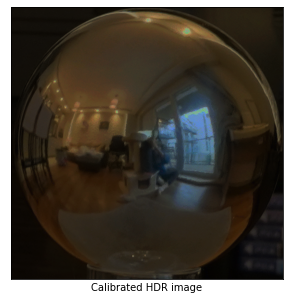

In [14]:
_calib_hdr_image = get_hdr_image(calib_hdr_image)

show_images(
    [_calib_hdr_image], 
    ["Calibrated HDR image"],
    figsize=(5, 5)
)

### 2.4. Comparison
Wrapping up this section, I will compare these methods in terms of their complexity, accuracy, and the details they preserve in the HDR image.

#### Naive vs. Weighted
Difference between naive and weighted 

Min ratio =  1.0   Max ratio =  2.4714038397971123


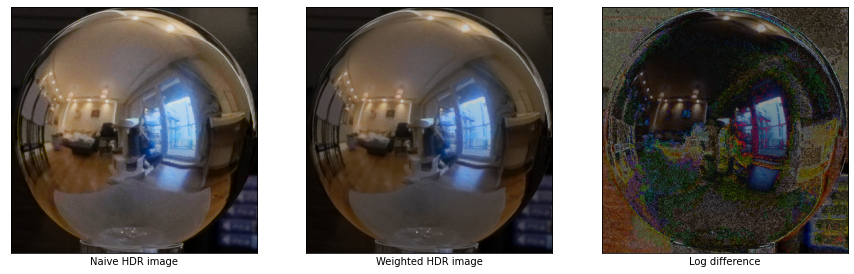

In [15]:
log_diff_im = np.log(weighted_hdr_image) - np.log(naive_hdr_image)
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())

show_images(
    [_naive_hdr_image, _weighted_hdr_image, rescale_images_linear(log_diff_im)], 
    ["Naive HDR image", "Weighted HDR image", "Log difference"]
)

#### Calibrated vs. Weighted

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Min ratio =  0.1557322246029198   Max ratio =  8.170913739255472


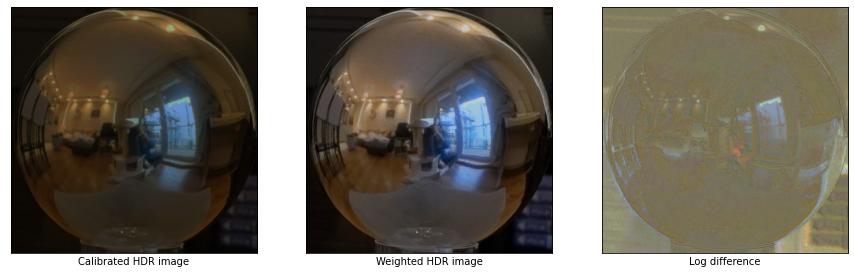

In [16]:
log_diff_im = np.log(calib_hdr_image / calib_hdr_image.mean()) - np.log(weighted_hdr_image / weighted_hdr_image.mean())
print('Min ratio = ', np.exp(log_diff_im).min(), '  Max ratio = ', np.exp(log_diff_im).max())

show_images(
    [_calib_hdr_image, _weighted_hdr_image, rescale_images_linear(log_diff_im)], 
    ["Calibrated HDR image", "Weighted HDR image", "Log difference"]
)

#### Intensity vs. g

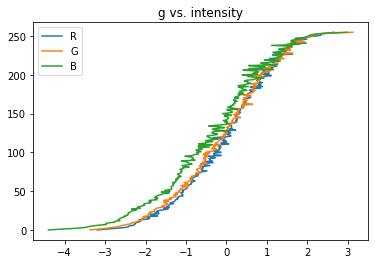

In [17]:
N, NG = g.shape
labels = ['R', 'G', 'B']
fig = plt.figure()
for n in range(N):
    plt.plot(g[n], range(NG), label=labels[n])
plt.title("g vs. intensity")
plt.gca().legend(('R', 'G', 'B'))

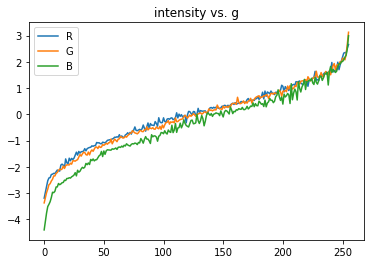

In [18]:
fig = plt.figure()
for n in range(N):
    plt.plot(range(NG), g[n], label=labels[n])
plt.title("intensity vs. g")
plt.gca().legend(('R', 'G', 'B'))

#### Weighted log error

In [19]:
def weighted_log_error(ldr_images: np.array, hdr_image: np.array, log_irradiances: np.array) -> float:
    '''
    Computes weighted RMS error of log irradiances for each image compared to final log irradiance
    :param ldr_images: N ldr images
    :param hdr_image: hdr image
    :param log_irradiances: N log irradiances
    :return: Weighted log error
    '''
    N, H, W, C = ldr_images.shape
    w = 1-abs(ldr_images - 0.5)*2
    err = 0
    for n in np.arange(N):
        err += np.sqrt(np.multiply(w[n], (log_irradiances[n]-np.log(hdr_image))**2).sum()/w[n].sum())/N 
        
    return err

In [20]:
err = weighted_log_error(ldr_images, naive_hdr_image, naive_log_irradiances)
print('naive:  \tlog range = ', round(np.log(naive_hdr_image).max() - np.log(naive_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, weighted_hdr_image, naive_log_irradiances)
print('weighted:\tlog range = ', round(np.log(weighted_hdr_image).max() - np.log(weighted_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))
err = weighted_log_error(ldr_images, calib_hdr_image, calib_log_irradiances)
print('calibrated:\tlog range = ', round(np.log(calib_hdr_image).max() - np.log(calib_hdr_image).min(),3), '\tavg RMS error = ', round(err,3))

naive:  	log range =  6.553 	avg RMS error =  0.371
weighted:	log range =  7.059 	avg RMS error =  0.285
calibrated:	log range =  8.466 	avg RMS error =  0.123


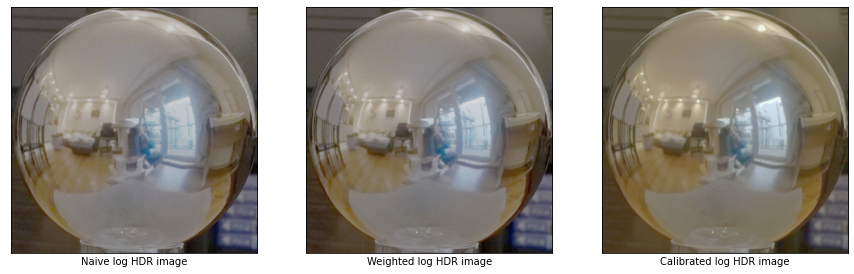

In [21]:
errors = np.log(np.stack(
    (
        naive_hdr_image / naive_hdr_image.mean(), 
        weighted_hdr_image / weighted_hdr_image.mean(), 
        calib_hdr_image / calib_hdr_image.mean()
    ), axis=0)
)

show_images(
    rescale_images_linear(errors), 
    ["Naive log HDR image", "Weighted log HDR image", "Calibrated log HDR image"]
)

## 3. Rendering synthetic objects into photographs
This part of the project delves into the concept of integrating synthetic objects into real-life photographs, a practical application of the Image-Based Lighting (IBL) technique. With the HDR image at hand, it involves understanding how to render these objects and merge them seamlessly with an HDR environment, thus, giving them a realistic look.

### 3.1. Panoramic transformations
Once we have the HDR image of a spherical mirror, it can be utilized for image-based lighting. Due to compatibility issues with some programs, the "mirror ball" format needs to be converted into a widely accepted panoramic format, such as equirectangular. This section presents a detailed exploration of the transformation process.

In [22]:
def _rescale(A):
    return ((A - A.min()) * 2) / (A.max() - A.min()) - 1


def panoramic_transform(hdr_image: np.array) -> np.array:
    '''
    Map reflection vectors into spherical coordinates and interpolate spherical coordinate values into equirectangular grid.
    :param hdr_image: N hdr image
    :return: Equirectangular image, and reflections and normals (for visualization)
    '''
    H, W, C = hdr_image.shape
    assert H == W
    assert C == 3
    
    X, Y = np.meshgrid(range(W), range(H))
    
    # rescale to -1 - 1
    X = _rescale(X)
    Y = _rescale(Y)
    
    # compute Z (z^2 = 1 - x^2 - y^2)
    Z = np.sqrt(1 - np.clip(X**2 + Y**2, a_min=0 ,a_max=1))
    
    # create circular mask
    mask = (np.sqrt((X)**2 + (Y)**2)) <= 1
    
    # construct normals
    N = np.zeros((H, W, C))
    N[:,:,0] = X * mask
    N[:,:,1] = Y * mask
    N[:,:,2] = Z * mask
    
    # construct viewing direction vectors
    V = np.zeros((H, W, C))
    V[:,:,2] = -1 * mask
    
    # compute reflection vectors
    R = np.zeros((H, W, C))
    for c in range(C):
        R[:,:,c] = V[:,:,c] + 2 * Z * N[:,:,c]
  
    equirectangular_image = get_equirectangular_image(R, hdr_image)
    
    return equirectangular_image, (N+1)/2, (R+1)/2

In [23]:
hdr_mirrorball_image = _calib_hdr_image

eq_image, normals, reflections = panoramic_transform(hdr_mirrorball_image)

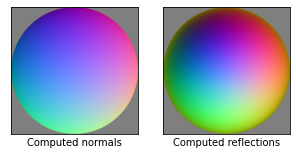

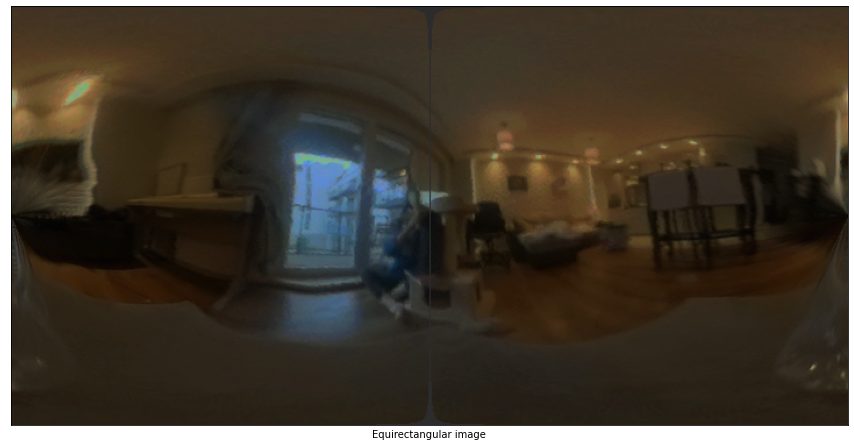

In [24]:
show_images(
    [normals, reflections],
    ["Computed normals", "Computed reflections"],
    figsize=(5, 5)
)
show_images(
    [eq_image],
    ["Equirectangular image"]
)

### 3.2 Rendering synthetic objects into photographs 
The last part is to render synthetic objects with Blender 2.8 into the phorograph. The process involves creating differential render composites using a specific pixel-wise equation. The purpose of this step is to create a composite image where the synthetic objects, lit with our HDR environment, blend seamlessly into a real photograph. This composite is created in such a way that it takes into account the original photograph (the background image), the rendered image with objects, the rendered image without objects, and an object mask. This approach allows for a high level of control over the integration of rendered objects into the photograph, resulting in a convincing, photorealistic image.

In [25]:
obj_img = read_image('results/rendered_objs.png')
plane_img = read_image('results/rendered_plane.png')
mask_img = read_image('results/rendered_mask.png')

In [26]:
O = obj_img
E = plane_img
M = mask_img > 0.5
I = cv2.resize(background_image, (M.shape[1], M.shape[0]))

c = 1.5
result = M*O + (1-M)*I + (1-M)*(O-E)*c
result = np.clip(result, 0, 1)

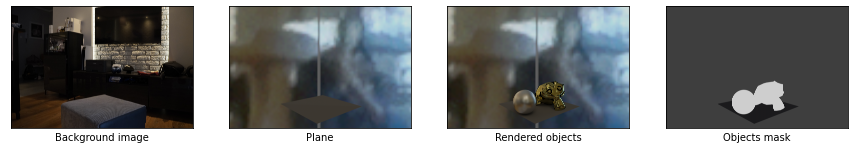

In [27]:
show_images(
    [background_image, plane_img, obj_img, mask_img],
    ["Background image", "Plane", "Rendered objects", "Objects mask"]
)

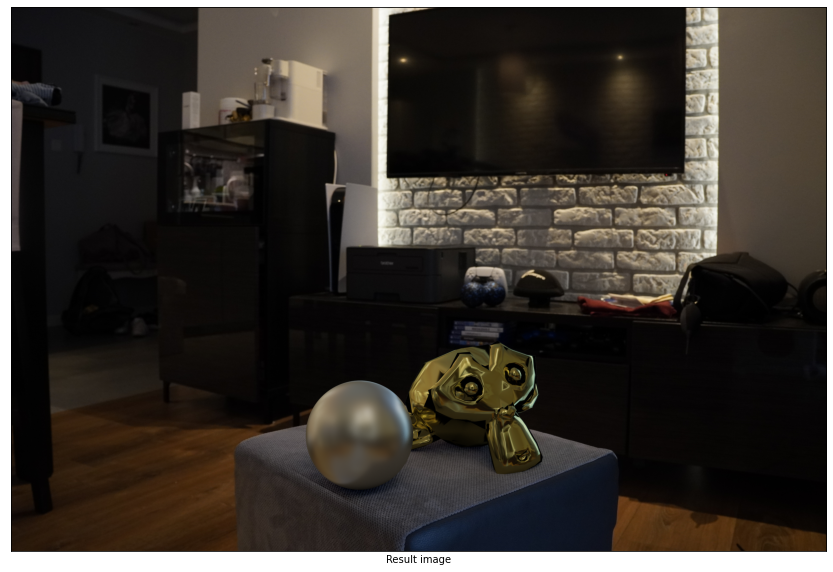

In [28]:
show_images(
    [result],
    ["Result image"]
)